In [38]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/Users/matt/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [39]:
# see the whole width of the table
pd.options.display.max_columns = 60
pd.options.display.max_rows = 20

# default plot settings
matplotlib.rc("figure", figsize=(12, 7))

# Read in data

Let's take a cheeky look at the data. It's in the FASTA format:

https://en.wikipedia.org/wiki/FASTA_format

Here's the example from the challenge email:

In [40]:
example_input = """>Frag_56
ATTAGACCTG
>Frag_57
CCTGCCGGAA
>Frag_58
AGACCTGCCG
>Frag_59
GCCGGAATAC
"""

example_output = "ATTAGACCTGCCGGAATAC"

In [41]:
with open('data/coding_challenge_data_set.txt') as f:
    fasta_input = f.read()
    
print(fasta_input[:3000])

>Rosalind_1836
GCGCCCGGGGCAAGAGTCATTATACTTGAGAATATACATTTAACAGCGGGCTCATAGCAC
AGCAGTTATAAAAGAGGCAGATTCCGACCCCTTAGGGACTATAGGTTTTCTGGGTGTCAA
CCCTTCGTGGTACTAGCGGGCGGCAATCCCTTAAATATCTAGGCCCGTACCATCGACAGG
GCAGATTGGCATTTATTTCTGGGCCTACACAAATGCGAATAACGATTACTAGCCGAGCAC
TCTCTTTTATGACAAGAGGGTTTCACATCCTCTTAGTATGTCCCGCACAATAACTTTTGC
GCAAAAGTGCTCTTGTTTATTTAGTGAATATCCAGGGGTAAGTGCTAATATGTGAGCGCT
GCTCTGCAGTTATGATGACCGGTTCATAGTTGCTCGTATTGGCACATGTACGGAAAGGCA
AATCATTCAAGTTTTGGGGAGGAATATGGCGGCCCACCTCCTTGGCCCACGGAGTCCCGC
CTTTGCGCTGGTGAAGGTGTCACTGCCCCCTAGATCATACCGCACTAAGTGGGGCCTGTA
TCGAAGGGTTTCTTGTTTAGGACAATCTTTGCTGTCTTCTTCACCCAATCACAGCTTGAT
TGAATGAGTAATCACTGAACATCGGGAGGCTCCATTTACCTAAGAATTCAGACGCCTGGT
TGGATCTGTGAGACACTCACGTATGGATGTTAACGACAAGGCACCTGGGGTACTTGTAAC
AAGTCATACACTATGCTGGGTACTACCCCAACGCAGAGTTTATGCCCCCATGCCACCGTT
GCCTTCACGTCACCACCATTCATCATCTAGCGAGGCCCTGGTGTCCTATTTTGTAGAGGG
GATATCTAGTGAGGGCCTATCATGCCACGGACGAGAACATAAAAATCTATAAAGAGCCTG
GTTCGATTCTGATAACCTAAAAGCTAAAACTGAGATGTTTGGCCCTTCGCGGGACCTGCA
GGTCGAGCT

# Shape the data

In [42]:
from collections import Counter

class Sequence:
    def __init__(self, paragraph):
        self.name, bases = paragraph.split('\n', 1)
        self.bases = bases.replace('\n', '') # get rid of line wrapping
        
    def __repr__(self):
        n = 10
        ellipsis = '...' if len(self.bases) > n else ''
        return self.name + ': ' + self.bases[:n] + ellipsis

def sequences(fasta_string):
    paragraphs = fasta_string.split('>')[1:]
    return list(map(Sequence, paragraphs))

def counts_df(seqs):
    sequence_counts = {seq.name: Counter(seq.bases) for seq in seqs}
    return pd.DataFrame(sequence_counts).T

In [43]:
example_seqs = sequences(example_input)
seqs                  = sequences(fasta_input)
example_seqs, seqs[:5]

([Frag_56: ATTAGACCTG,
  Frag_57: CCTGCCGGAA,
  Frag_58: AGACCTGCCG,
  Frag_59: GCCGGAATAC],
 [Rosalind_1836: GCGCCCGGGG...,
  Rosalind_9816: TAGTGTGGGA...,
  Rosalind_5517: GGCGAACATA...,
  Rosalind_7782: GAAAGCGAAA...,
  Rosalind_5929: CCGACTGGAC...])

In [44]:
example_counts = counts_df(example_seqs)
counts                  = counts_df(seqs)
counts.head()

,A,C,G,T
Rosalind_0030,257,247,234,260
Rosalind_0087,262,239,227,253
Rosalind_0093,249,248,234,252
Rosalind_0312,286,226,249,231
Rosalind_0368,253,254,231,255


# Plot the data

### How long are these sequences?

/Users/matt/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


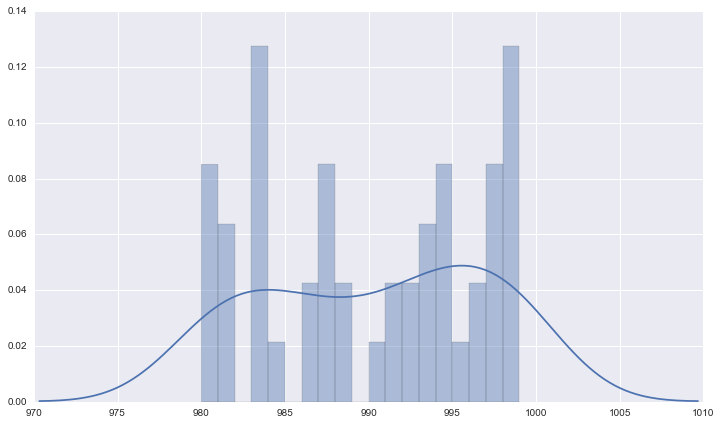

In [45]:
sequence_lengths = counts.sum(axis=1)
bin_range = range(sequence_lengths.min(), sequence_lengths.max())
sns.distplot(sequence_lengths, bins=bin_range)

### What does the nucleotide distribution look like? Sanity check: any outliers?

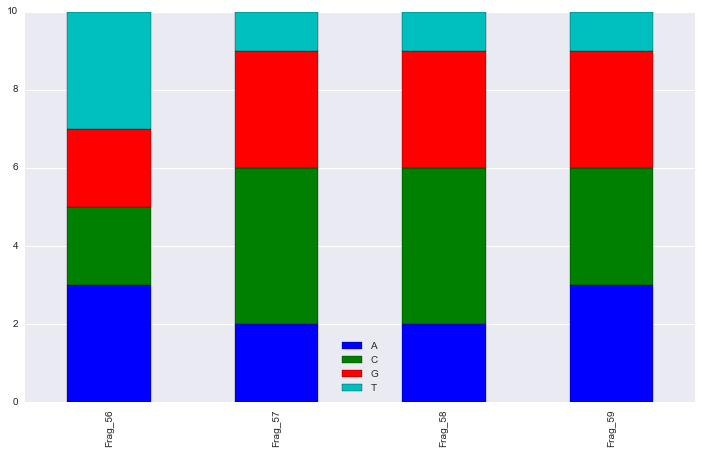

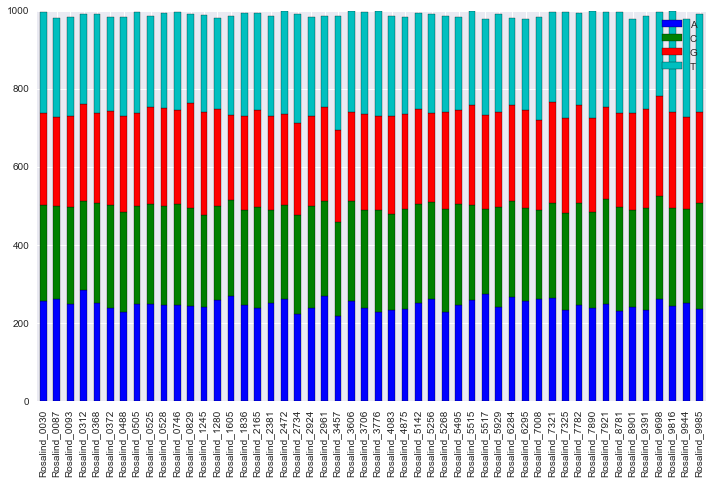

In [46]:
example_counts.plot.bar(stacked=True)
counts.plot.bar(stacked=True)

# Find pairwise overlaps

## Brute force

In [47]:
from collections import defaultdict
import networkx as nx

# adjacency list, where for each edge,
# overlap is the suffix of source node and the prefix of sink node
overlap_graph = defaultdict(set)
network = nx.DiGraph()


for i in range(len(seqs)):
    # add nodes even if they don't have an outdegree
    overlap_graph[i] = set()
    
    for j in range(len(seqs)):
        if i is j: continue # don't overlap string with itself
        
        seq_i, seq_j = seqs[i].bases, seqs[j].bases
        len_i, len_j = len(seq_i), len(seq_j)
        
        min_i_overlap = len_i//2 + 1
        min_j_overlap = len_j//2 + 1
        min_overlap = max(min_i_overlap, min_j_overlap)
        
        # check each string is long enough for the other
        if len_i < min_overlap or len_j < min_overlap: continue
        
        for overlap in range(min_overlap, min(len_i, len_j)+1):
            if seq_i[-overlap:] == seq_j[:overlap]:
                overlap_graph[i].add(j)
                network.add_edge(i, j, overlap=overlap)
                break #winning

overlap_graph

defaultdict(set,
            {0: {17},
             1: {48},
             2: {35},
             3: {14},
             4: {40},
             5: {46},
             6: {3},
             7: {20},
             8: {11},
             9: {31},
             10: {21},
             11: {38},
             12: {32},
             13: {44},
             14: {25},
             15: {6},
             16: {42},
             17: {39},
             18: {16},
             19: {34},
             20: {26},
             21: {37},
             22: {49},
             23: {29},
             24: {2},
             25: {45},
             26: {27},
             27: {43},
             28: {9},
             29: {10},
             30: set(),
             31: {33},
             32: {13},
             33: {47},
             34: {15},
             35: {22},
             36: {19},
             37: {28},
             38: {23},
             39: {30},
             40: {41},
             41: {1},
             42: {24},
        

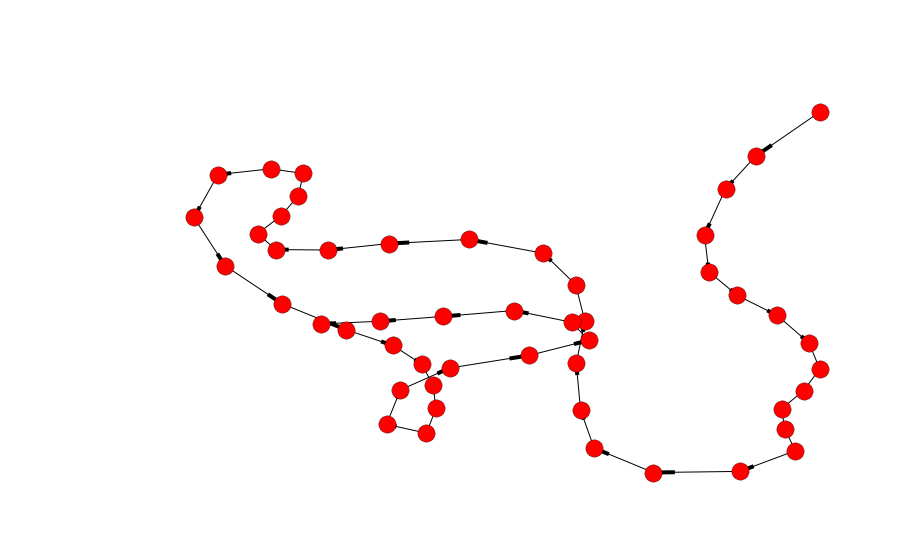

In [48]:
nx.draw(network)

In [76]:
import networkx as nx

def without_node(graph, node):
    return graph.subgraph(n for n in graph if n != node)

def find_hamiltonian_paths(digraph):
    n = len(digraph)
    if n == 0: return []
    
    partial_hamiltonians = [([node], digraph) for node in digraph]
    hamiltonians = []
    
    while partial_hamiltonians:
        base_path, graph = partial_hamiltonians.pop()
        tip = base_path[-1]
        for successor in graph.successors(tip):
            path = base_path + [successor]
            if len(path) == n:
                hamiltonians.append(path)
            subgraph = without_node(graph, tip)
            partial_hamiltonians.append((path, subgraph))
            
    return hamiltonians

find_hamiltonian_paths(network)

[[8,
  11,
  38,
  23,
  29,
  10,
  21,
  37,
  28,
  9,
  31,
  33,
  47,
  4,
  40,
  41,
  1,
  48,
  36,
  19,
  34,
  15,
  6,
  3,
  14,
  25,
  45,
  18,
  16,
  42,
  24,
  2,
  35,
  22,
  49,
  12,
  32,
  13,
  44,
  7,
  20,
  26,
  27,
  43,
  5,
  46,
  0,
  17,
  39,
  30]]

# Strongly connected component with more than one node and exactly one Hamiltonian

Smallest graph with complete transitive closure and unique Hamiltonian path:


[[0, 1, 2, 3, 4]]

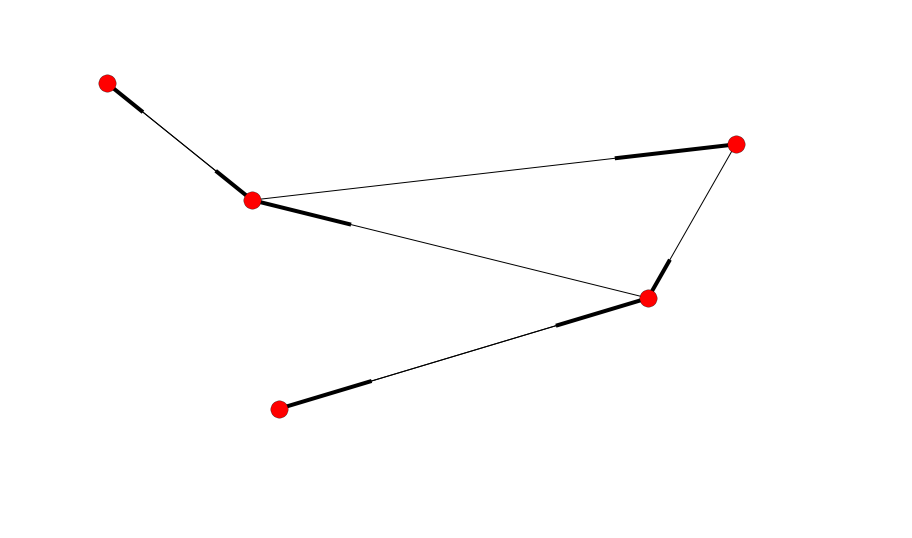

In [78]:
g = nx.DiGraph()
g.add_edge(1,2)
g.add_cycle(range(2))
g.add_cycle(range(1,4))
g.add_cycle((3,4))
print("Smallest graph with complete transitive closure and unique Hamiltonian path:")
nx.draw(g)
find_hamiltonian_paths(g)